In [31]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller



# BTC

## Step #1: Read Data

In [32]:
# Read data
df = pd.read_csv('../../Dataset/BTC-USD-3.2018-3.2024.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...,...
2188,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
2189,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
2190,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,62504.789063,83239156760
2191,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,61198.382813,65496611844


## Step #2: Explore the Data

In [33]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")

Dataset Shape: (2193, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2018-03-01 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2193 non-null   float64
 1   High       2193 non-null   float64
 2   Low        2193 non-null   float64
 3   Close      2193 non-null   float64
 4   Adj Close  2193 non-null   float64
 5   Volume     2193 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.9 KB
Dataset Info: None
Dataset Describe:                Open          High           Low         Close     Adj Close  \
count   2193.000000   2193.000000   2193.000000   2193.000000   2193.000000   
mean   22705.310922  23217.108536  22164.070169  22727.117088  22727.117088   
std    16415.707425  16828.247923  15967.197094  16431.977633  16431.977633   
min     3236.274658   3275.377930   3191.303467   3236.761719   3236.761719   
25%     8370.049805   8585.150391   8185.763184

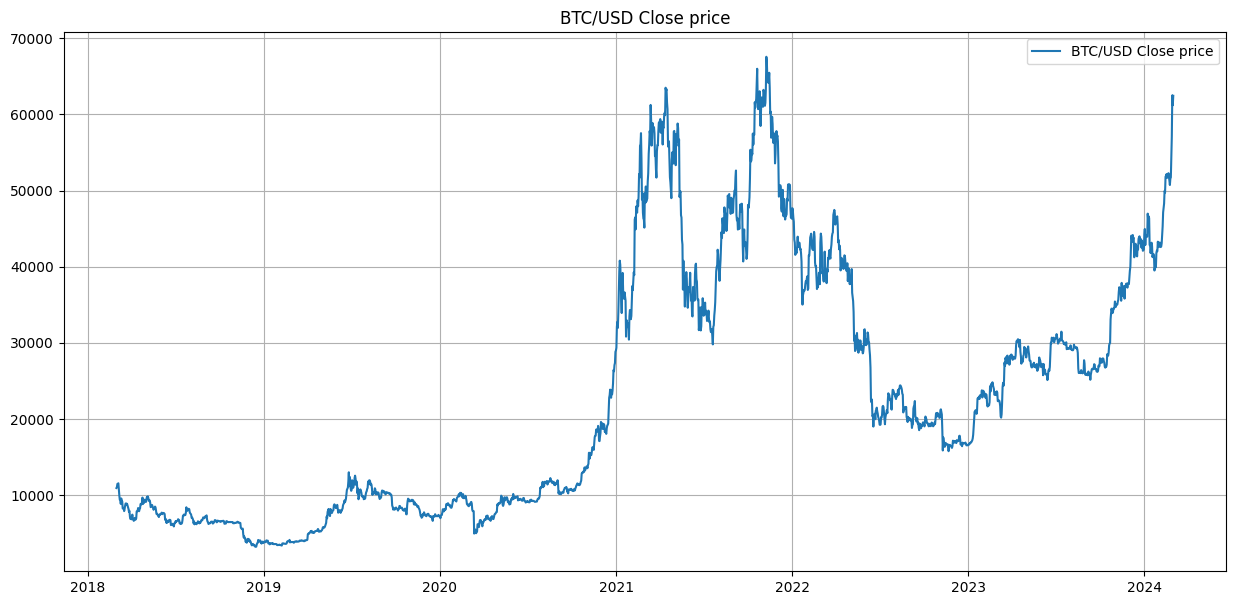

In [34]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='BTC/USD Close price')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


## Step #3: Feature Engineering

In [35]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)

    return df

                   Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                                 
2024-02-26  54522.402344   2011.481276             55562.917072             44094.380584  48217.373648   49732.990195
2024-02-27  57085.371094   2149.034185             55554.945143             45246.125560  48676.596605   50189.124685
2024-02-28  62504.789063   2436.766487             56183.950977             45893.834570  49215.427284   50845.910058
2024-02-29  61198.382813   3066.746602             58540.114919             45257.992894  49958.463041   51956.279487
2024-03-01  62440.632813   3421.157344             60049.935273             45153.290900  50658.698918   52836.479803
                  Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                     

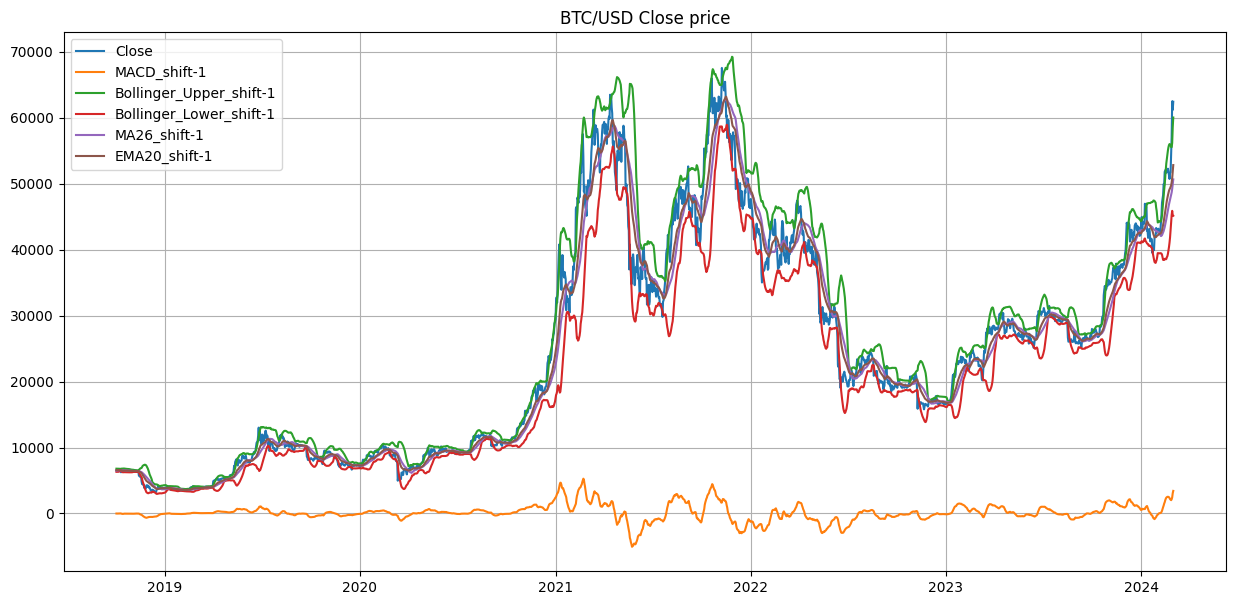

In [36]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


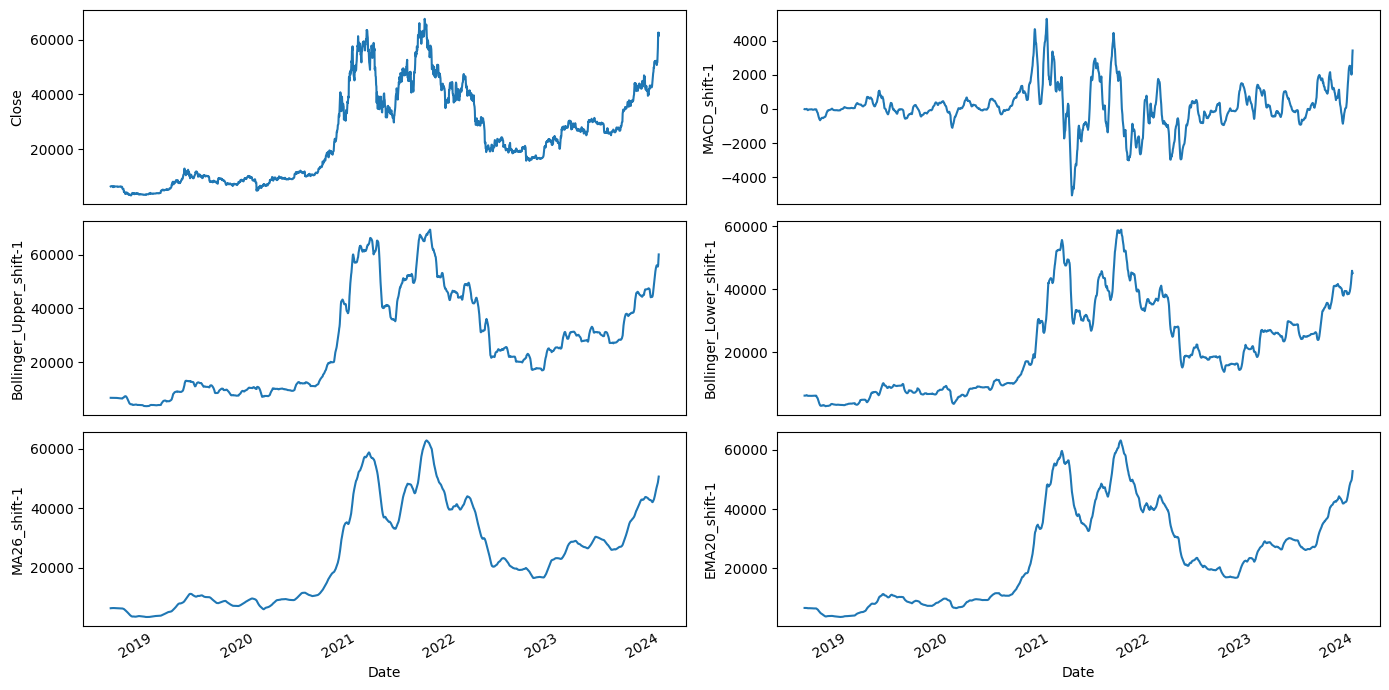

In [37]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

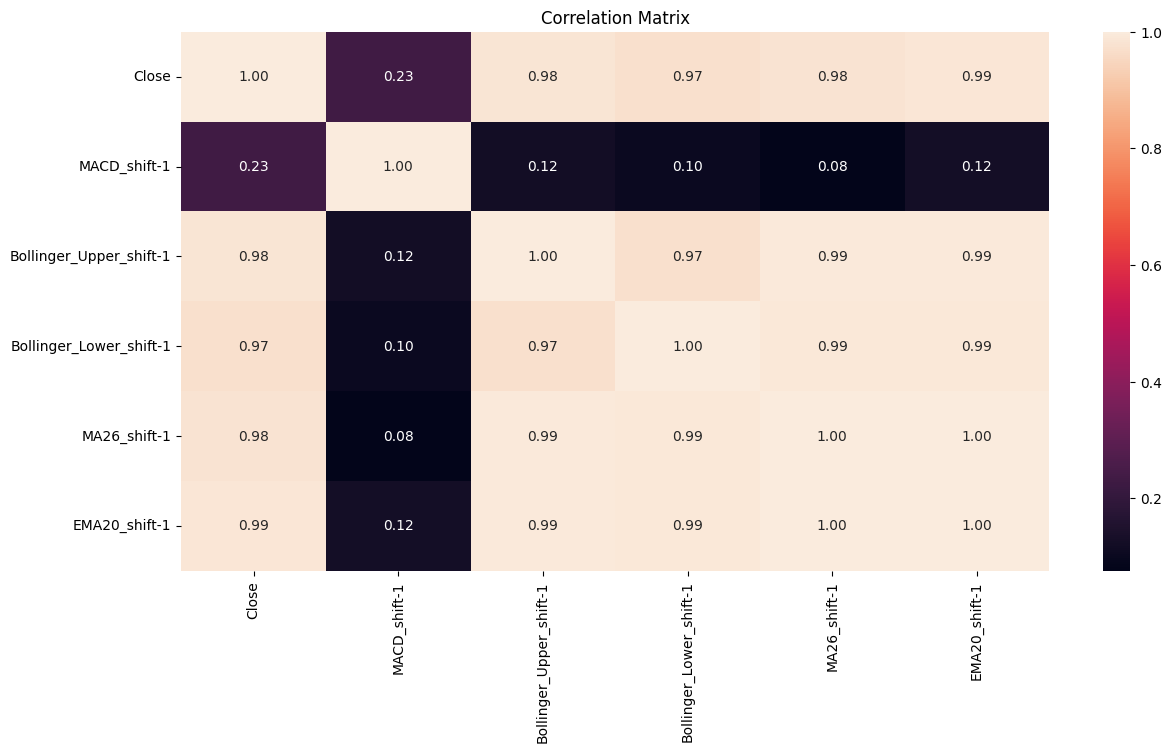

In [38]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [39]:
# Granger causality test to check if the past values of the time series affect the current value of the time series
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 24
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)



,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0000,0.0,0.0000,0.0,0.0,0.0
High_y,0.0000,1.0,0.0000,0.0,0.0,0.0
Low_y,0.0000,0.0,1.0000,0.0,0.0,0.0
Close_y,0.0001,0.0,0.0001,1.0,1.0,0.0
Adj Close_y,0.0001,0.0,0.0001,1.0,1.0,0.0
Volume_y,0.0000,0.0,0.0000,0.0,0.0,1.0


## Step #4: Train & Test split

In [40]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

train, test = split_data(df_filtered, test_size=0.1) 

In [41]:
print(df_filtered.shape)
print(train.shape)
print(test.shape)

(1977, 6)
(1780, 6)
(197, 6)


## Step #5: Model Specification

**VAR**

**1. Check for stationary**

In [42]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [43]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*"*50 + f" Differencing of order {diff_order} " + "*"*50)
    train_diff = pd.DataFrame(np.diff(train, diff_order, axis=0), columns=train.columns)
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'Close' -> p-value: 0.815
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.001
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_shift-1' -> p-value: 0.823
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower_shift-1' -> p-value: 0.686
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_shift-1' -> p-value: 0.806
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_shift-1' -> p-value: 0.568
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'MACD_shift-1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF T

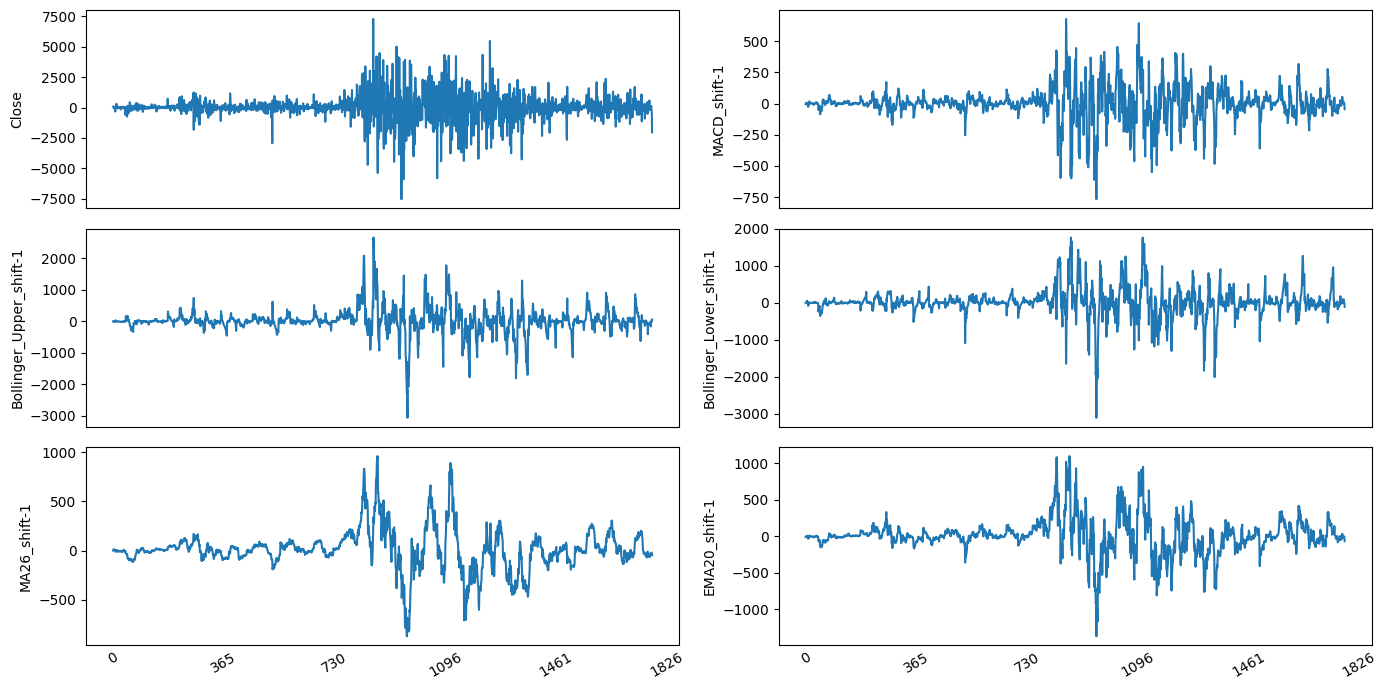

In [44]:
# Plot line charts
df_plot = train_diff.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF')

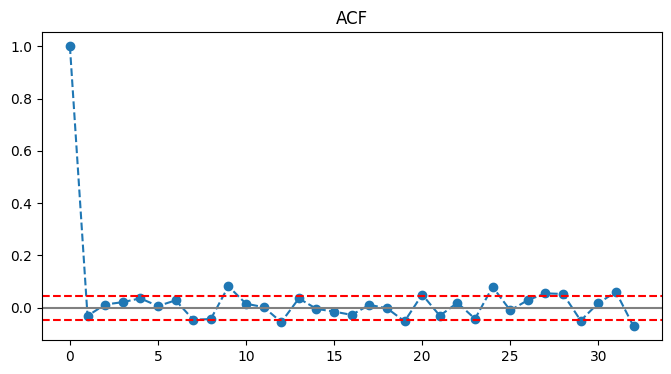

In [45]:
import statsmodels.tsa.stattools as ts
acf_plot = ts.acf(train_diff['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.title('ACF')

In [46]:
model = VAR(train_diff)
sorted_order = model.select_order(maxlags=10)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        64.27       64.29   8.195e+27       64.28
1       -14.70      -14.57   4.147e-07      -14.65
2       -65.89      -65.65   2.420e-29      -65.80
3       -66.90      -66.55   8.812e-30      -66.77
4       -67.39      -66.93   5.381e-30      -67.22
5       -67.92      -67.34   3.193e-30      -67.70
6       -127.1      -126.4   6.148e-56      -126.9
7       -127.3      -126.5   5.055e-56      -127.0
8       -127.5      -126.6   4.356e-56      -127.1
9      -128.0*     -126.9*  2.668e-56*     -127.6*
10      -127.9      -126.8   2.723e-56      -127.5
--------------------------------------------------


In [47]:
# Fỉt VAR model
model = VAR(train_diff)
model_fitted = model.fit(9)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, May, 2024
Time:                     21:55:28
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -126.670
Nobs:                     1770.00    HQIC:                  -127.314
Log likelihood:           98268.0    FPE:                3.50155e-56
AIC:                     -127.692    Det(Omega_mle):     2.91422e-56
--------------------------------------------------------------------
Results for equation Close
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                     8.392342        24.149788            0.348           0.728
L1.Close                                 -0.026301         0.024186           -1.

In [48]:
# Forecast test set
def forecast(model, df, steps):
    print(f"Forecasting {steps} steps")
    df_forecast = df.copy()
    for i in range(steps):
        X_forecast = df_forecast[-model.k_ar:]
        forecast = model_fitted.forecast(y=X_forecast.values, steps=1)
        print(f"Forecasting step {i+1}: {forecast}")
        df_fc = pd.DataFrame(forecast, columns=df.columns)
        df_forecast = pd.concat([df_forecast, df_fc], ignore_index=True)
    return df_forecast.iloc[-steps:]


In [49]:
forecast = model_fitted.forecast(y=train.values, steps=len(test))
df_forecast = pd.DataFrame(forecast, columns=train_diff.columns)
df_forecast

,Close,MACD_shift-1,Bollinger_Upper_shift-1,Bollinger_Lower_shift-1,MA26_shift-1,EMA20_shift-1
0,7616.000000,-321.423321,29280.000000,27424.000000,29206.900316,29075.533209
1,6976.000000,-1991.425288,28336.000000,25392.000000,28342.725736,27031.768141
2,5312.000000,-3328.191213,26928.000000,24416.000000,27488.844351,25121.694985
3,5312.000000,-4470.327579,25808.000000,23184.000000,26569.021635,23235.057367
4,4928.000000,-5314.219859,24816.000000,21888.000000,25644.291917,21528.099523
...,...,...,...,...,...,...
192,10.062500,-0.257924,10.652344,8.347656,9.224459,10.209967
193,9.921875,-0.248527,10.679688,8.460938,9.295673,10.195922
194,10.031250,-0.249550,10.703125,8.539062,9.365385,10.169823
195,9.953125,-0.238782,10.718750,8.632812,9.438702,10.156625


In [50]:
fc_test = forecast(model_fitted, train, len(test))
fc_test.index = test.index

fc_test


TypeError: 'numpy.ndarray' object is not callable